In [82]:
# Importing the necessary libraries

import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
import geopandas as gpd
import json
import warnings
import time
from os import listdir
from os.path import isfile,join
import datetime
from branca.element import MacroElement
from matplotlib.colors import rgb2hex
from jinja2 import Template
import folium
from branca.colormap import LinearColormap
import matplotlib
import matplotlib.ticker as ticker
import requests

In [34]:
def get_covid_data(info='cases'):
    if info == 'cases':
        url = ('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/'
               'csse_covid_19_time_series/time_series_covid19_confirmed_US.csv').format(sep=2*'\n')
        ren_col = 'Total_cases'
        val_col = 'Daily_cases'
    if info =='deaths':
            url = ('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/'
                    'csse_covid_19_time_series/time_series_covid19_deaths_US.csv').format(sep=2*'\n')
            ren_col = 'Total_deaths'
            val_col = 'Daily_deaths'
    df = pd.read_csv(url)
    df = df[df['iso3']=='USA']
    df = df.dropna(subset = ['FIPS'])
    df = df[df.FIPS <= 56045]

    df.FIPS = df.FIPS.astype(int).astype(str).str.zfill(5)
    df = df[(df.Admin2 != 'Unassigned' ) & (df.Admin2.notna() )]
    df = df.drop(columns= ['UID','iso2', 'iso3', 'code3','Country_Region','Combined_Key' ])
    date_cols = [col for col in df.columns if '/20' in col]
    id_cols = [col for col in df.columns if col not in date_cols]
    df_gr = df.melt(id_vars=id_cols,value_vars=date_cols)
    df_gr[val_col] = df_gr.groupby(['FIPS'])[['value']].diff().fillna(0)
    df_gr = df_gr.rename(columns = {'value':ren_col, 'variable':'date', 
                                    'Long_':'Lng', 'Admin2':'COUNTY', 
                                   'Province_State': 'STATE', 'FIPS':'fips'})
    df_gr.date = pd.to_datetime( df_gr.date, infer_datetime_format=True)
    df_gr = df_gr.drop(columns = ['STATE', 'COUNTY'])
    return df_gr
    

In [35]:
df_covid_cases = get_covid_data(info='cases')
df_covid_deaths = get_covid_data(info='deaths')[['fips','date','Total_deaths','Daily_deaths']]
df_covid = pd.merge(left = df_covid_cases, right = df_covid_deaths, on = ['fips', 'date'])
df_covid

,fips,Lat,Lng,date,Total_cases,Daily_cases,Total_deaths,Daily_deaths
0,01001,32.539527,-86.644082,2020-01-22,0,0.0,0,0.0
1,01003,30.727750,-87.722071,2020-01-22,0,0.0,0,0.0
2,01005,31.868263,-85.387129,2020-01-22,0,0.0,0,0.0
3,01007,32.996421,-87.125115,2020-01-22,0,0.0,0,0.0
4,01009,33.982109,-86.567906,2020-01-22,0,0.0,0,0.0
...,...,...,...,...,...,...,...,...
565555,56037,41.659439,-108.882788,2020-07-19,173,2.0,0,0.0
565556,56039,43.935225,-110.589080,2020-07-19,208,11.0,0,0.0
565557,56041,41.287818,-110.547578,2020-07-19,221,0.0,0,0.0
565558,56043,43.904516,-107.680187,2020-07-19,44,1.0,0,0.0


In [13]:
def get_mobility_data(rolling_mean=False):
    mob_index_url = 'https://raw.githubusercontent.com/descarteslabs/DL-COVID-19/master/DL-us-mobility-daterow.csv'
    
    df_mobility_index = pd.read_csv(mob_index_url, parse_dates=['date'])
    df_mobility_index = df_mobility_index.dropna(subset=['fips','admin2'])
    df_mobility_index.fips = df_mobility_index.fips.astype(int)
    df_mobility_index.fips = df_mobility_index.fips.astype(str).str.zfill(5)
    df_mobility_index = df_mobility_index.rename(columns={'admin1':'STATE','admin2':'COUNTY' })
    df_mobility_index = df_mobility_index.drop(columns = ['country_code', 'admin_level'])
    
    if rolling_mean:
        mob_col= ['m50']
        m50 = df_mobility_index.groupby(['fips','date'])[mob_col].mean()
        m50['rolling_mean_mob'] = m50[mob_col].rolling(7,min_periods=1).mean()
        m50 = m50.reset_index()
        return m50
    
    return df_mobility_index

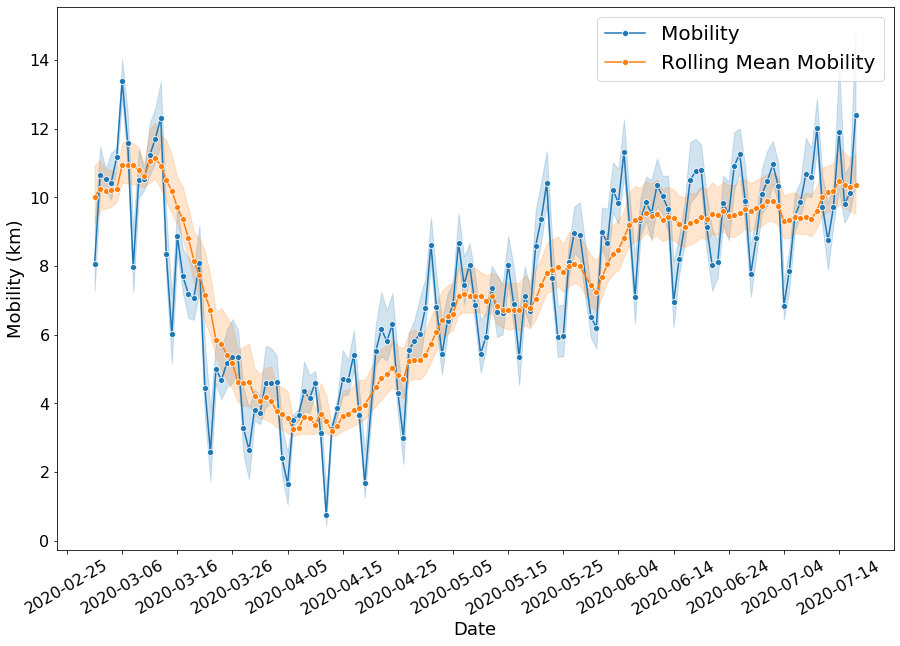

In [15]:
df_mobility = get_mobility_data()
df_mobility_rm = get_mobility_data(rolling_mean=True)
plt.figure(figsize=(15,10))
sns.lineplot(x='date', y = 'm50', data=df_mobility, marker='o',ci=99,label = 'Mobility')
sns.lineplot(x='date', y = 'rolling_mean_mob', data=df_mobility_rm, marker='o',ci=99, label = 'Rolling Mean Mobility')
plt.xlabel('Date', fontsize = 18)
plt.ylabel('Mobility (km)', fontsize = 18)
plt.xticks(fontsize=16, rotation=30)
plt.yticks(fontsize=16)
plt.legend(fontsize = 20)
ax=plt.gca()
ax.xaxis.set_major_locator(ticker.MultipleLocator(10))

In [22]:
df_mobility

,date,STATE,COUNTY,fips,samples,m50,m50_index
137,2020-03-01,Alabama,Autauga County,01001,1703,7.194,49
138,2020-03-02,Alabama,Autauga County,01001,1829,14.587,100
139,2020-03-03,Alabama,Autauga County,01001,1840,13.865,95
140,2020-03-04,Alabama,Autauga County,01001,1900,13.880,95
141,2020-03-05,Alabama,Autauga County,01001,1825,14.659,100
...,...,...,...,...,...,...,...
369856,2020-07-13,Wyoming,Uinta County,56041,732,5.584,178
369857,2020-07-14,Wyoming,Uinta County,56041,651,5.035,160
369858,2020-07-15,Wyoming,Uinta County,56041,700,6.373,203
369859,2020-07-16,Wyoming,Uinta County,56041,760,6.832,218


In [16]:
# Importing County Level spending data from https://github.com/Opportunitylab/EconomicTracker
county_spending_url =  'https://raw.githubusercontent.com/Opportunitylab/EconomicTracker/main/data/Affinity%20-%20County%20-%20Daily.csv'
df_county_spending = pd.read_csv(county_spending_url)

df_county_spending['date'] = df_county_spending['year'].astype(str) + '-' + \
                            df_county_spending['month'].astype(str) + '-' + \
                            df_county_spending['day'].astype(str)
df_county_spending.date = pd.to_datetime(df_county_spending.date, infer_datetime_format=True)
df_county_spending.countyfips = df_county_spending.countyfips.astype(int)
df_county_spending.countyfips = df_county_spending.countyfips.astype(str).str.zfill(5)
df_county_spending = df_county_spending.rename(columns={'countyfips':'fips'})
print(df_county_spending.fips.nunique())

df_county_spending

1487


,year,month,day,fips,spend_all,date
0,2020,1,24,01001,0.17700,2020-01-24
1,2020,1,24,01003,0.06100,2020-01-24
2,2020,1,24,01009,0.00878,2020-01-24
3,2020,1,24,01015,-0.01960,2020-01-24
4,2020,1,24,01021,0.09500,2020-01-24
...,...,...,...,...,...,...
248324,2020,7,8,56037,0.01380,2020-07-08
248325,2020,7,8,56039,0.22600,2020-07-08
248326,2020,7,8,56041,-0.06790,2020-07-08
248327,2020,7,8,56043,0.02100,2020-07-08


(737485.0, 737623.0)

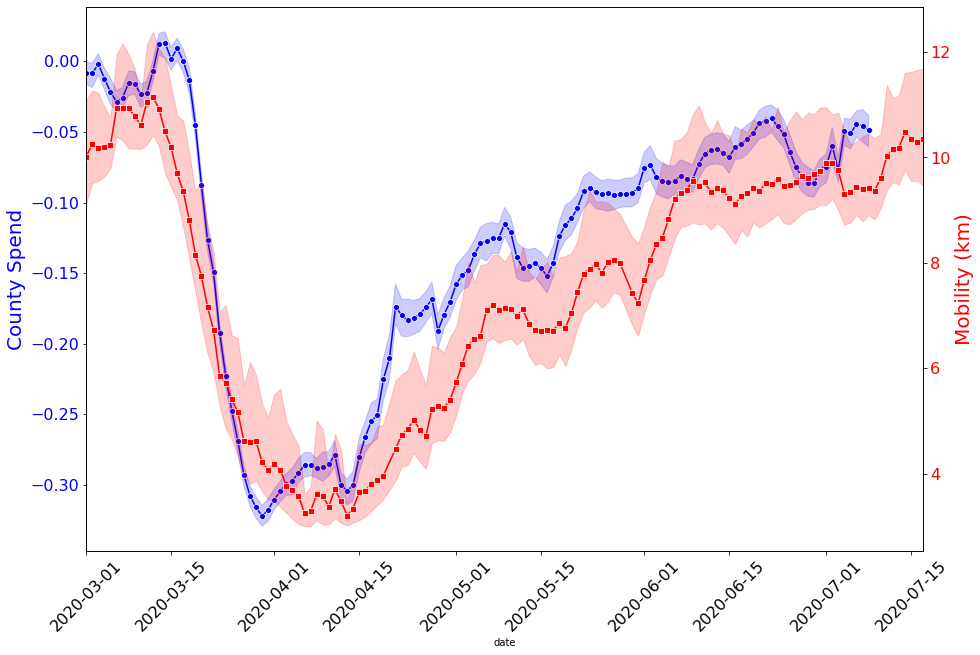

In [21]:
plt.figure(figsize=(15,10))
ax = sns.lineplot(x='date', y = 'spend_all', data=df_county_spending, marker='o',ci=100,color='blue')
plt.ylabel('County Spend', color='blue', fontsize=20)
plt.xticks(fontsize=16,rotation=45)
plt.yticks(fontsize=16,color='blue')
ax2 = ax.twinx()
sns.lineplot(x='date', y = 'rolling_mean_mob', data=df_mobility_rm, marker='s',ci=100, ax =ax2, color = 'red')
plt.ylabel('Mobility (km)',color='red', fontsize=20)
plt.yticks(fontsize=16,color='red')
plt.xlim(df_mobility_rm.date.min(), df_mobility_rm.date.max())

In [156]:
df_mob_covid = pd.merge(left = df_mobility, right = df_covid, on = ['fips', 'date'], how='outer')
df_mob_covid['Weekday'] = df_mob_covid.date.dt.day_name()
df_mob_covid = df_mob_covid.dropna(subset=['Lat'])

fips_lat_lng = df_mob_covid[['fips','Lat','Lng']].drop_duplicates().set_index('fips').to_dict('index')

In [342]:
# Get API keys from config file
def get_weather_chunk(lat,lng,start_dt, end_dt,API_KEY):
    
    url = 'https://api.worldweatheronline.com/premium/v1/past-weather.ashx'
    query = '?q=' + str(lat) + ','+str(lng)
    key = '&key=' + API_KEY
    ret_format = '&format=json'
    sdate = '&enddate='+ start_dt
    edate = '&date=' + end_dt
    tp = '&tp=24'
    final_url = url + query + ret_format +  edate + sdate + tp + key
    get_weather = requests.get(final_url)
    weather_data = json.loads(get_weather.text)
    
    #df = pd.DataFrame(weather_data['data']['weather'])
    return weather_data

def get_weather_data(lat,lng, start_date,end_date,fips,key_count):
    new_low = datetime.datetime.strptime(end_date, '%Y-%m-%d')
    new_end = datetime.timedelta(days=34) + new_low
    final_end = datetime.datetime.strptime(start_date, '%Y-%m-%d')
    df = pd.DataFrame()
    API_KEYS = list_of_API_KEYS
    last=False
    API_KEY=API_KEYS[key_count]
    #key_count=0
    while(last==False):
        if new_end <final_end:
            
            end_dt = datetime.datetime.strftime(new_low,'%Y-%m-%d' )
            start_dt = datetime.datetime.strftime(new_end,'%Y-%m-%d' )
            
            weather_data = get_weather_chunk(lat,lng,start_dt, end_dt,API_KEY)
            while( 'error' in weather_data['data']):
                
                print('Error', API_KEY)
                    
            
                key_count+=1
                if key_count == len(API_KEYS):
                    raise Exception('Out of API Keys')
                API_KEY=API_KEYS[key_count]
                weather_data = get_weather_chunk(lat,lng,start_dt, end_dt,API_KEY)
            df_weather_chunk = pd.DataFrame(weather_data['data']['weather'])
            df = pd.concat([df,df_weather_chunk], ignore_index=True)
            new_low = new_end + datetime.timedelta(days=1)
            last_itr = new_end
            new_end = datetime.timedelta(days=34) + new_low

           
        else:
            new_low = last_itr + datetime.timedelta(days=1)
            new_end = final_end
            end_dt = datetime.datetime.strftime(new_low,'%Y-%m-%d' )
            start_dt = datetime.datetime.strftime(new_end,'%Y-%m-%d' )
            weather_data = get_weather_chunk(lat,lng,start_dt, end_dt,API_KEY)
            df_weather_chunk = pd.DataFrame(weather_data['data']['weather'])
            df = pd.concat([df,df_weather_chunk], ignore_index=True)
            last = True

    df = df.drop(columns=['uvIndex'])
    df_h = pd.DataFrame()
    
    for val in df['hourly'].values:
        df_h = pd.concat([df_h, pd.DataFrame(val)], ignore_index=True)
    
    df = pd.concat([df, df_h], axis=1)
    use_cols = ['date','tempC', 'maxtempC', 'mintempC','WindChillC','FeelsLikeC', 'visibilityMiles','HeatIndexC', 
            'avgtempC', 'windspeedMiles', 'winddirDegree','pressure', 'WindGustMiles','precipMM',
            'totalSnow_cm' , 'sunHour', 'DewPointC','humidity','uvIndex']
    df = df[use_cols]
    cols= [col for col in df.columns if col!='date']
    df= df.apply(pd.to_numeric, errors='ignore')
    df.date = pd.to_datetime(df.date, infer_datetime_format=True)
    df['fips'] = fips
    return df,key_count

In [343]:
start_date = datetime.datetime.strftime(df_mob_covid.date.max(), '%Y-%m-%d')
end_date =  datetime.datetime.strftime(df_mob_covid.date.min(), '%Y-%m-%d')

fpath1 = './Data/Weather_Files/'
os.makedirs(fpath1, exist_ok=True)
files_all = [fpath1+f for f in listdir(fpath1) if isfile(join(fpath1, f))]
weather_files = [f for f in files_all if 'Weather' in f]
fips_done = [file.split('_')[3].split('.csv')[0] for file in weather_files]
key_count = 0
for fips,lat_lng in list(fips_lat_lng.items()):
    if fips in fips_done:
        
        continue
    else:
        
        lat,lng = lat_lng['Lat'],lat_lng['Lng']
        weather_df,key_count = get_weather_data(lat,lng, start_date,end_date,fips,key_count)
        weather_df.to_csv(fpath1 + 'Weather_FIPS_'+str(fips)+'.csv',index=False)

In [161]:
fpath1 = './Data/Weather_Files/'
files_all = [fpath1+f for f in listdir(fpath1) if isfile(join(fpath1, f))]
weather_files = [f for f in files_all if 'Weather' in f]
fips_done = [file.split('_')[3].split('.csv')[0] for file in weather_files]

df_weather = pd.DataFrame()
i=0
for file in weather_files:
    df = pd.read_csv(file)
    df_weather = pd.concat([df_weather,df], ignore_index=True)
    i+=1
    if i%300 == 0:
        print('Finised Records', i)
df_weather.date = pd.to_datetime(df_weather.date, infer_datetime_format=True)
df_weather.to_csv('./Data/All_County_Weather'+start_date+'.csv', index=False)
df_weather

Finised Records 300
Finised Records 600
Finised Records 900
Finised Records 1200
Finised Records 1500
Finised Records 1800
Finised Records 2100
Finised Records 2400
Finised Records 2700
Finised Records 3000


,date,tempC,maxtempC,mintempC,WindChillC,FeelsLikeC,visibilityMiles,HeatIndexC,avgtempC,windspeedMiles,winddirDegree,pressure,WindGustMiles,precipMM,totalSnow_cm,sunHour,DewPointC,humidity,uvIndex,fips
0,2020-01-22,8,8,-2,0,0,6,3,4,5,105,1028,9,0.0,0.0,6.9,-8,49,1,1001
1,2020-01-23,8,8,2,3,3,3,5,5,8,96,1020,12,34.5,0.0,5.3,3,86,1,1001
2,2020-01-24,14,14,7,10,10,5,11,12,7,268,1016,11,17.2,0.0,10.0,8,82,4,1001
3,2020-01-25,11,11,2,4,4,6,6,7,6,293,1021,9,0.0,0.0,10.0,2,76,3,1001
4,2020-01-26,11,11,4,7,7,6,7,8,2,136,1020,4,0.1,0.0,6.9,4,78,2,1001
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
565555,2020-07-15,24,24,9,16,16,6,17,18,6,220,1014,8,0.7,0.0,14.5,7,58,5,56045
565556,2020-07-16,28,28,13,21,21,6,21,23,6,186,1012,9,0.3,0.0,14.5,6,42,6,56045
565557,2020-07-17,31,31,17,24,24,6,24,26,7,275,1007,11,0.0,0.0,14.5,7,42,7,56045
565558,2020-07-18,24,24,14,20,20,6,21,20,9,251,1011,12,0.0,0.0,14.5,8,48,6,56045


In [185]:
df_weather.fips = df_weather.fips.astype(str).str.zfill(5)
df_mob_covid_weather = pd.merge(left = df_mob_covid, right = df_weather, on =['date', 'fips'])
df_mob_covid_weather

,date,STATE,COUNTY,fips,samples,m50,m50_index,Lat,Lng,Total_cases,...,windspeedMiles,winddirDegree,pressure,WindGustMiles,precipMM,totalSnow_cm,sunHour,DewPointC,humidity,uvIndex
0,2020-03-01,Alabama,Autauga County,01001,1703.0,7.194,49.0,32.539527,-86.644082,0.0,...,6,193,1023,10,0.0,0.0,11.3,6,68,4
1,2020-03-02,Alabama,Autauga County,01001,1829.0,14.587,100.0,32.539527,-86.644082,0.0,...,7,188,1016,12,21.4,0.0,5.7,12,88,3
2,2020-03-03,Alabama,Autauga County,01001,1840.0,13.865,95.0,32.539527,-86.644082,0.0,...,7,247,1012,12,24.5,0.0,5.7,17,93,4
3,2020-03-04,Alabama,Autauga County,01001,1900.0,13.880,95.0,32.539527,-86.644082,0.0,...,9,28,1014,15,75.7,0.0,5.7,13,94,3
4,2020-03-05,Alabama,Autauga County,01001,1825.0,14.659,100.0,32.539527,-86.644082,0.0,...,10,143,1015,16,16.2,0.0,5.7,10,92,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
565555,2020-07-19,NaN,NaN,56037,NaN,NaN,NaN,41.659439,-108.882788,173.0,...,12,273,1014,16,0.0,0.0,14.5,-1,23,6
565556,2020-07-19,NaN,NaN,56039,NaN,NaN,NaN,43.935225,-110.589080,208.0,...,5,245,1015,7,0.0,0.0,14.5,1,43,5
565557,2020-07-19,NaN,NaN,56041,NaN,NaN,NaN,41.287818,-110.547578,221.0,...,12,282,1014,16,0.0,0.0,11.6,1,29,6
565558,2020-07-19,NaN,NaN,56043,NaN,NaN,NaN,43.904516,-107.680187,44.0,...,6,139,1013,9,0.0,0.0,14.5,4,28,7


In [189]:
df_county = pd.read_csv('./Data/nhgis0010_ds239_20185_2018_county.csv', encoding='latin')
df_county['fips'] = df_county.STATEA.astype(str).str.zfill(2)+df_county.COUNTYA.astype(str).str.zfill(3)
df_gini_income = pd.read_csv('./Data/nhgis0010_ds240_20185_2018_county.csv', encoding='latin')
df_gini_income = df_gini_income[['STATE', 'COUNTY', 'AKGVE001']]
df_county_demo = pd.merge(left = df_county , right = df_gini_income, on =['STATE', 'COUNTY'])
cols_A = df_county_demo.columns[df_county_demo.columns.str.endswith('A')]
margin_cols = [col for col in df_county_demo.columns if 'M' in col[4:5]]

df_county_demo = df_county_demo.drop(columns = ['GISJOIN']+list(cols_A) + margin_cols )
df_county_demo.head(2)

,YEAR,STATE,COUNTY,NAME_E,AJWBE001,AJWBE002,AJWBE003,AJWBE004,AJWBE005,AJWBE006,...,AJ35E060,AJ35E061,AJ35E062,AJ35E063,AJ35E064,AJ35E065,AJ35E066,NAME_M,fips,AKGVE001
0,2014-2018,Alabama,Autauga County,"Autauga County, Alabama",55200,26874,1789,2021,1754,1256,...,1310,1387,455,0,32,2458,0,"Autauga County, Alabama",01001,0.4602
1,2014-2018,Alabama,Baldwin County,"Baldwin County, Alabama",208107,101188,5855,5551,7544,4134,...,7046,8078,1462,4,760,9752,162,"Baldwin County, Alabama",01003,0.4609


In [190]:
import re
f = open('./Data/nhgis0010_ds239_20185_2018_county_codebook.txt','r') 
searchlines = f.readlines()
f.close()
for i in range(len(searchlines)):
    if '    Margins of error' in searchlines[i] :
        error_margin = i
col_dict={}
for col in df_county_demo.columns[4:]:
    for i, line in enumerate(searchlines):
        #print(i)
        if col[:-4] in line and 'Table' in searchlines[i-3] and i <error_margin :
            text = re.sub(r"\s+", " ", searchlines[i-3].strip())
            top_col = text.split(':')[1].strip()
        if col in line:
            text = line.strip().split(':')[1:]
            col_name = ''.join(map(str, text))
            col_name = re.sub(r"\s+", " ", col_name).strip()
            #print(col_name)
            col_dict[col] = top_col+ '_' + col_name
        
df_county_demo = df_county_demo.rename(columns=col_dict)
insurance_cols = [col for col in df_county_demo.columns if 'Insurance' in col]
hispanic_cols = [col for col in df_county_demo.columns if 'Hispanic' in col]

df_county_demo = df_county_demo.drop(columns=insurance_cols+hispanic_cols)
df_county_demo.head(2)

,YEAR,STATE,COUNTY,NAME_E,Sex by Age_Total,Sex by Age_Male,Sex by Age_Male Under 5 years,Sex by Age_Male 5 to 9 years,Sex by Age_Male 10 to 14 years,Sex by Age_Male 15 to 17 years,...,Gross Rent as a Percentage of Household Income in the Past 12 Months_15.0 to 19.9 percent,Gross Rent as a Percentage of Household Income in the Past 12 Months_20.0 to 24.9 percent,Gross Rent as a Percentage of Household Income in the Past 12 Months_25.0 to 29.9 percent,Gross Rent as a Percentage of Household Income in the Past 12 Months_30.0 to 34.9 percent,Gross Rent as a Percentage of Household Income in the Past 12 Months_35.0 to 39.9 percent,Gross Rent as a Percentage of Household Income in the Past 12 Months_40.0 to 49.9 percent,Gross Rent as a Percentage of Household Income in the Past 12 Months_50.0 percent or more,Gross Rent as a Percentage of Household Income in the Past 12 Months_Not computed,fips,AKGVE001
0,2014-2018,Alabama,Autauga County,"Autauga County, Alabama",55200,26874,1789,2021,1754,1256,...,475.0,725.0,339.0,393.0,194.0,336.0,1509.0,718.0,01001,0.4602
1,2014-2018,Alabama,Baldwin County,"Baldwin County, Alabama",208107,101188,5855,5551,7544,4134,...,2390.0,2221.0,2183.0,1775.0,1516.0,1336.0,3961.0,2961.0,01003,0.4609


In [191]:
total_cols = [col for col in df_county_demo.columns if 'Total' in col]
for col in total_cols:
    remaining_cols = [c for c in list(df_county_demo.columns) if c!=col]
    for df_col in remaining_cols:
        if col.split('_')[0] in df_col:
            df_county_demo[df_col] = df_county_demo[df_col]/df_county_demo[col]
df_county_demo         

,YEAR,STATE,COUNTY,NAME_E,Sex by Age_Total,Sex by Age_Male,Sex by Age_Male Under 5 years,Sex by Age_Male 5 to 9 years,Sex by Age_Male 10 to 14 years,Sex by Age_Male 15 to 17 years,...,Gross Rent as a Percentage of Household Income in the Past 12 Months_15.0 to 19.9 percent,Gross Rent as a Percentage of Household Income in the Past 12 Months_20.0 to 24.9 percent,Gross Rent as a Percentage of Household Income in the Past 12 Months_25.0 to 29.9 percent,Gross Rent as a Percentage of Household Income in the Past 12 Months_30.0 to 34.9 percent,Gross Rent as a Percentage of Household Income in the Past 12 Months_35.0 to 39.9 percent,Gross Rent as a Percentage of Household Income in the Past 12 Months_40.0 to 49.9 percent,Gross Rent as a Percentage of Household Income in the Past 12 Months_50.0 percent or more,Gross Rent as a Percentage of Household Income in the Past 12 Months_Not computed,fips,AKGVE001
0,2014-2018,Alabama,Autauga County,"Autauga County, Alabama",55200,0.486848,0.032409,0.036612,0.031775,0.022754,...,0.089606,0.136767,0.063950,0.074137,0.036597,0.063384,0.284663,0.135446,01001,0.4602
1,2014-2018,Alabama,Baldwin County,"Baldwin County, Alabama",208107,0.486231,0.028135,0.026674,0.036251,0.019865,...,0.115231,0.107083,0.105250,0.085579,0.073092,0.064413,0.190974,0.142761,01003,0.4609
2,2014-2018,Alabama,Barbour County,"Barbour County, Alabama",25782,0.531262,0.027810,0.026026,0.035374,0.018385,...,0.106881,0.115905,0.091089,0.062324,0.031021,0.080090,0.215454,0.183023,01005,0.4731
3,2014-2018,Alabama,Bibb County,"Bibb County, Alabama",22527,0.539442,0.030719,0.028899,0.030630,0.024016,...,0.049267,0.059238,0.099707,0.095601,0.039296,0.031085,0.203519,0.199413,01007,0.4294
4,2014-2018,Alabama,Blount County,"Blount County, Alabama",57645,0.493260,0.031451,0.029369,0.036742,0.021077,...,0.072905,0.122417,0.109925,0.072905,0.061549,0.055417,0.140586,0.221894,01009,0.4331
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3215,2014-2018,Puerto Rico,Vega Baja Municipio,"Vega Baja Municipio, Puerto Rico",53371,0.479287,0.023777,0.024358,0.037061,0.020910,...,0.081954,0.086024,0.047218,0.031750,0.061872,0.027680,0.115332,0.503392,72145,0.5095
3216,2014-2018,Puerto Rico,Vieques Municipio,"Vieques Municipio, Puerto Rico",8771,0.493900,0.032835,0.031239,0.024969,0.007297,...,0.073746,0.098820,0.047198,0.017699,0.008850,0.000000,0.244838,0.433628,72147,0.4542
3217,2014-2018,Puerto Rico,Villalba Municipio,"Villalba Municipio, Puerto Rico",22993,0.485757,0.028313,0.033141,0.029661,0.025312,...,0.052302,0.048279,0.094323,0.052302,0.016540,0.017881,0.088511,0.537774,72149,0.5172
3218,2014-2018,Puerto Rico,Yabucoa Municipio,"Yabucoa Municipio, Puerto Rico",34149,0.484377,0.022080,0.032065,0.029869,0.020908,...,0.030941,0.055693,0.016399,0.027847,0.028775,0.029084,0.155322,0.617265,72151,0.5104


In [197]:
df_all = pd.merge(left = df_mob_covid_weather.drop(columns=['STATE', 'COUNTY']), right = df_county_demo, on = ['fips'])
# Removing the dates before March 1 for mobility predictions
df_all_mob = df_all[(df_all.date >= df_mobility.date.min()) 
                                            & (df_all.date <= df_mobility.date.max())]

#Eventual Test data for which we do not have mobility values
df_mob_null = df_all_mob.mask(df_all_mob.isnull())
# Defining the training dataset
df_mob_train = df_all_mob.dropna()
df_mob_train

,date,fips,samples,m50,m50_index,Lat,Lng,Total_cases,Daily_cases,Total_deaths,...,Gross Rent as a Percentage of Household Income in the Past 12 Months_10.0 to 14.9 percent,Gross Rent as a Percentage of Household Income in the Past 12 Months_15.0 to 19.9 percent,Gross Rent as a Percentage of Household Income in the Past 12 Months_20.0 to 24.9 percent,Gross Rent as a Percentage of Household Income in the Past 12 Months_25.0 to 29.9 percent,Gross Rent as a Percentage of Household Income in the Past 12 Months_30.0 to 34.9 percent,Gross Rent as a Percentage of Household Income in the Past 12 Months_35.0 to 39.9 percent,Gross Rent as a Percentage of Household Income in the Past 12 Months_40.0 to 49.9 percent,Gross Rent as a Percentage of Household Income in the Past 12 Months_50.0 percent or more,Gross Rent as a Percentage of Household Income in the Past 12 Months_Not computed,AKGVE001
0,2020-03-01,01001,1703.0,7.194,49.0,32.539527,-86.644082,0.0,0.0,0.0,...,0.091115,0.089606,0.136767,0.063950,0.074137,0.036597,0.063384,0.284663,0.135446,0.4602
1,2020-03-02,01001,1829.0,14.587,100.0,32.539527,-86.644082,0.0,0.0,0.0,...,0.091115,0.089606,0.136767,0.063950,0.074137,0.036597,0.063384,0.284663,0.135446,0.4602
2,2020-03-03,01001,1840.0,13.865,95.0,32.539527,-86.644082,0.0,0.0,0.0,...,0.091115,0.089606,0.136767,0.063950,0.074137,0.036597,0.063384,0.284663,0.135446,0.4602
3,2020-03-04,01001,1900.0,13.880,95.0,32.539527,-86.644082,0.0,0.0,0.0,...,0.091115,0.089606,0.136767,0.063950,0.074137,0.036597,0.063384,0.284663,0.135446,0.4602
4,2020-03-05,01001,1825.0,14.659,100.0,32.539527,-86.644082,0.0,0.0,0.0,...,0.091115,0.089606,0.136767,0.063950,0.074137,0.036597,0.063384,0.284663,0.135446,0.4602
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
480372,2020-07-13,56041,732.0,5.584,178.0,41.287818,-110.547578,205.0,3.0,0.0,...,0.071093,0.127026,0.167277,0.091479,0.099320,0.055410,0.061683,0.124412,0.077365,0.4002
480373,2020-07-14,56041,651.0,5.035,160.0,41.287818,-110.547578,208.0,3.0,0.0,...,0.071093,0.127026,0.167277,0.091479,0.099320,0.055410,0.061683,0.124412,0.077365,0.4002
480374,2020-07-15,56041,700.0,6.373,203.0,41.287818,-110.547578,208.0,0.0,0.0,...,0.071093,0.127026,0.167277,0.091479,0.099320,0.055410,0.061683,0.124412,0.077365,0.4002
480375,2020-07-16,56041,760.0,6.832,218.0,41.287818,-110.547578,217.0,9.0,0.0,...,0.071093,0.127026,0.167277,0.091479,0.099320,0.055410,0.061683,0.124412,0.077365,0.4002


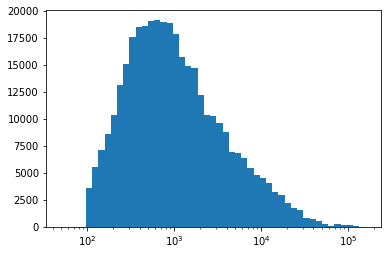

In [269]:
data = df_mobility['samples']
plt.hist(data, bins=np.logspace(np.log10(50),np.log10(df_mobility['samples'].max()), 50))
plt.xscale("log")
#plt.yscale("log")

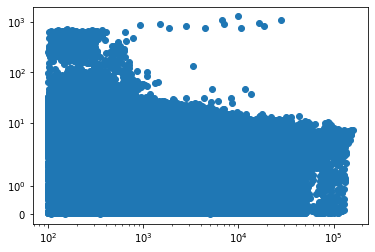

In [273]:
plt.scatter(df_mobility['samples'],df_mobility['m50'])
plt.xscale('log')
plt.yscale('symlog')

In [287]:
df_mob_train_pre = df_mob_train[df_mob_train.date < '2020-03-15']
#df_mob_train_pre = df_mob_train_pre[df_mob_train_pre.m50<200]
remove_cols = ['date','fips', 'samples','COUNTY','m50_index', 'Lat', 'Lng','YEAR','NAME_E' ]
target_var = ['m50']
df_final = df_mob_train_pre.drop(columns=remove_cols)
df_final = df_final.dropna()
X =df_final.drop(columns=target_var)
y =df_final[target_var]
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=42)

In [290]:
df_mob_train_covid = df_mob_train[df_mob_train.date >= '2020-03-15']
df_mob_train_covid = df_mob_train_covid[df_mob_train_covid.m50<200]
remove_cols = ['date','fips', 'samples','COUNTY','m50_index', 'Lat', 'Lng','YEAR','NAME_E' ]
target_var = ['m50']
df_final = df_mob_train_covid.drop(columns=remove_cols)
df_final = df_final.dropna()
X =df_final.drop(columns=target_var)
y =df_final[target_var]
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=42)

In [300]:
from sklearn.metrics import r2_score
import catboost
cat_index = [X.columns.get_loc("STATE"),X.columns.get_loc("Weekday")]
cb_model = catboost.CatBoostRegressor(task_type='GPU', n_estimators=1000, eval_metric='RMSE',
                                      max_depth=6, learning_rate=0.25,verbose=200,cat_features=cat_index)
# lin_model = Ridge()
# lin_model.fit(X_train,y_train)
cb_model.fit(X_train,y_train)
#y_pred_lin = lin_model.predict(X_test)
y_pred_cb = cb_model.predict(X_test)

#print(r2_score(y_test,y_pred_lin))
print(r2_score(y_test,y_pred_cb))

0:	learn: 5.4009287	total: 30.9ms	remaining: 30.9s
200:	learn: 2.4857068	total: 6.66s	remaining: 26.5s
400:	learn: 2.2210792	total: 13s	remaining: 19.4s
600:	learn: 2.0651704	total: 19.2s	remaining: 12.8s
800:	learn: 1.9547227	total: 25.8s	remaining: 6.41s
999:	learn: 1.8683250	total: 32.4s	remaining: 0us
0.8267155556294484


In [293]:
test = y_test.values.flatten()
test.shape

(65089,)

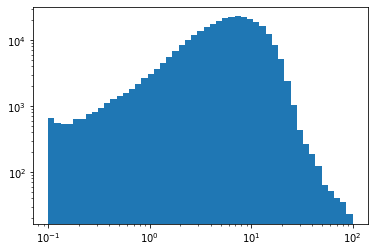

In [294]:
data = df_mob_train_covid['m50']
plt.hist(data, bins=np.logspace(np.log10(0.1),np.log10(100), 50))
plt.xscale("log")
plt.yscale("log")

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000002B54F58CEB8>]],
      dtype=object)

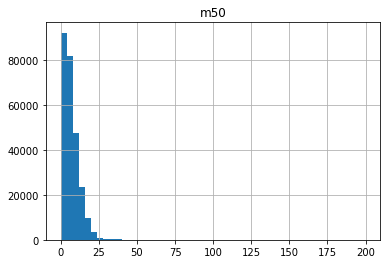

In [295]:
y_train.hist(bins=50,log=False)


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000002B52FA606A0>]],
      dtype=object)

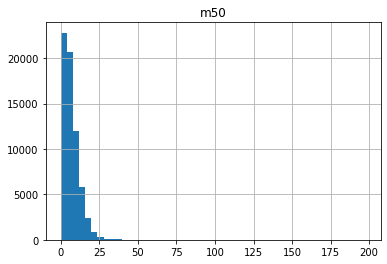

In [296]:
y_test.hist(bins=50)

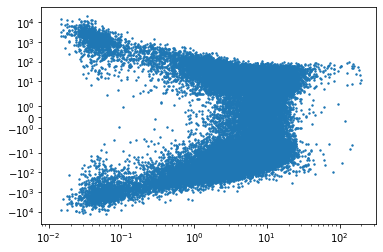

In [297]:
test = y_test.values.flatten()
plt.scatter(y_test,(test-y_pred_cb)*100/test,s=2)
plt.yscale('symlog')
plt.xscale('log')

In [305]:
df_mob_train_covid.date[y_test.index].values

array(['2020-05-16T00:00:00.000000000', '2020-07-15T00:00:00.000000000',
       '2020-05-19T00:00:00.000000000', ...,
       '2020-03-27T00:00:00.000000000', '2020-06-19T00:00:00.000000000',
       '2020-05-18T00:00:00.000000000'], dtype='datetime64[ns]')

In [334]:
y_test

,m50,date,err_pct
36075,1.741,2020-05-16,-6.429929
179054,12.408,2020-07-15,-11.489827
423618,7.203,2020-05-19,34.160872
177497,10.468,2020-03-18,-6.374768
400815,4.228,2020-07-16,-19.968674
...,...,...,...
97438,11.220,2020-04-29,14.727891
247924,6.134,2020-05-05,-12.818094
282086,1.106,2020-03-27,-34.608103
90468,4.626,2020-06-19,-7.482116


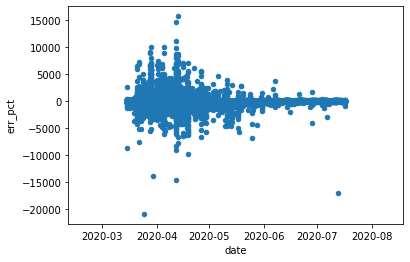

In [341]:
y_test.plot.scatter(x='date', y ='err_pct')
#plt.yscale('symlog')

C:\Users\swami\Anaconda3\envs\sparkenv\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\Users\swami\Anaconda3\envs\sparkenv\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


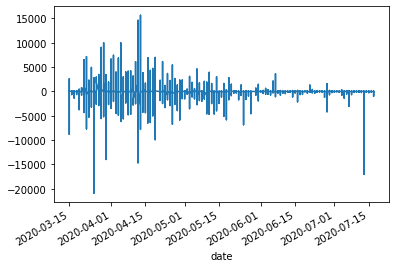

In [340]:
y_test['date'] = df_mob_train_covid.date[y_test.index]
y_test['err_pct'] = (test-y_pred_cb)*100/test
y_test.set_index('date')['err_pct'].plot()


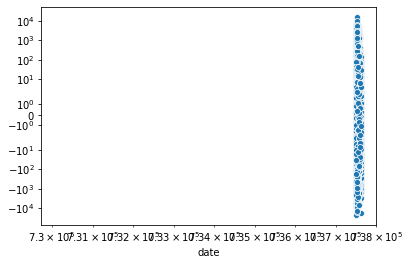

In [325]:
sns.scatterplot(y_test['date'].dt.date, (test-y_pred_cb)*100/test)
plt.yscale('symlog')
plt.xscale('log')

In [298]:
df_cb_feat_imp =  pd.DataFrame(cb_model.feature_importances_, X_train.columns,columns=['Post_Covid_Feature_Importance'])
df_cb_feat_imp.sort_values('Post_Covid_Feature_Importance',ascending=False)[:25]

,Post_Covid_Feature_Importance
Gross Rent as a Percentage of Household Income in the Past 12 Months_Total,7.438605
STATE,7.165573
Weekday,6.065812
tempC,4.978482
Travel Time to Work_10 to 14 minutes,4.223735
Gross Rent as a Percentage of Household Income in the Past 12 Months_Not computed,4.044054
Ratio of Income to Poverty Level in the Past 12 Months_Total,3.417249
sunHour,3.358970
Means of Transportation to Work_Bicycle,2.826988
Total_cases,2.728445


In [22]:
# Creating a dataframe to record reduction in spending and mobility before and after covid
target_cols = ['rolling_mean_mob','spend_all']
covid_date = datetime.datetime.strptime('2020-03-15', '%Y-%m-%d')
window = covid_date -datetime.timedelta(days=10)
df_covid = df_merged[df_merged.date>=window]
df_pre = df_merged[(df_merged.date<window)]
df_pre_mean = df_pre.groupby(['fips','date'])[target_cols].mean()

pre_covid_mean = df_pre_mean.groupby(level=[0])[target_cols].mean()
df_covid_mean = df_covid.groupby(['fips','date'])[target_cols].mean()


post_covid_min_date = df_covid_mean.groupby(level=[0])[target_cols].idxmin()
for col in target_cols:
    rename_col = 'min_date_' + col
    post_covid_min_date['min_date_'+col] = post_covid_min_date[col].str[1]
    post_covid_min_date = post_covid_min_date.drop(columns=[col])
post_covid_min = y.groupby(level=[0])[target_cols].min()
for col in target_cols:
    post_covid_min = post_covid_min.rename(columns={col:'Min_'+col})
df_mob_spend_red = pd.concat([pre_covid_mean,post_covid_min,post_covid_min_date],axis=1)

df_mob_spend_red = df_mob_spend_red.reset_index()
df_mob_spend_red = df_mob_spend_red.rename(columns={'index':'fips'})
for col in target_cols:
    min_date_col = 'min_date_' + col
    
    df_mob_spend_red['Drop_days_'+col] = (df_mob_spend_red[min_date_col] - covid_date).dt.days
    if col!='spend_all':
        df_mob_spend_red['Norm_Drop_Rate_'+col] = ((df_mob_spend_red[col] -df_mob_spend_red['Min_'+col])/df_mob_spend_red['Drop_days_'+col])/df_mob_spend_red[col]
        df_mob_spend_red['Pct_Red_'+col] =( df_mob_spend_red[col] - df_mob_spend_red['Min_'+col])/df_mob_spend_red[col]
    else:
        df_mob_spend_red['Norm_Drop_Rate_'+col] = ((-1*df_mob_spend_red['Min_'+col])/df_mob_spend_red['Drop_days_'+col])
        df_mob_spend_red['Pct_Red_'+col] = -1*df_mob_spend_red['Min_'+col]
df_mob_spend_red = df_mob_spend_red[df_mob_spend_red['Pct_Red_rolling_mean_mob']>=-0.5]
df_mob_spend_red.sample(5)

,fips,rolling_mean_mob,spend_all,Min_rolling_mean_mob,Min_spend_all,min_date_rolling_mean_mob,min_date_spend_all,Drop_days_rolling_mean_mob,Norm_Drop_Rate_rolling_mean_mob,Pct_Red_rolling_mean_mob,Drop_days_spend_all,Norm_Drop_Rate_spend_all,Pct_Red_spend_all
581,17117,8.280643,-0.039400,1.800571,-0.318,2020-03-28,2020-03-28,13.0,0.060197,0.782557,13.0,0.024462,0.318
60,01121,17.630429,-0.032879,4.720857,-0.236,2020-04-12,2020-03-29,28.0,0.026151,0.732232,14.0,0.016857,0.236
284,12023,6.964750,-0.032875,3.889286,-0.273,2020-04-19,2020-03-30,35.0,0.012616,0.441576,15.0,0.018200,0.273
89,04025,3.376964,0.015122,0.752714,-0.314,2020-04-13,2020-04-13,29.0,0.026797,0.777103,29.0,0.010828,0.314
326,12107,8.237857,-0.032957,3.531143,-0.194,2020-04-10,2020-03-29,26.0,0.021975,0.571352,14.0,0.013857,0.194


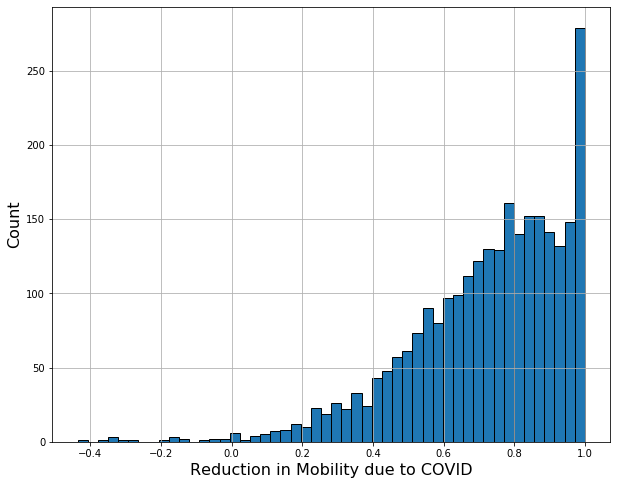

In [21]:
plt.figure(figsize=(10,8))
plt.rcParams["patch.force_edgecolor"] = True

df_mob_spend_red['Pct_Red_rolling_mean_mob'].hist(bins = 50)
plt.xlabel('Reduction in Mobility due to COVID', fontsize=16)
plt.ylabel('Count', fontsize = 16)
df_mob_spend_red['loc'] = df_mob_spend_red['fips'].apply(lambda x: get_county_state(county_dict,x))

In [47]:
df_mobility_index

,date,STATE,COUNTY,fips,samples,m50,m50_index
136,2020-03-01,Alabama,Autauga County,01001,1703,7.194,49
137,2020-03-02,Alabama,Autauga County,01001,1829,14.587,100
138,2020-03-03,Alabama,Autauga County,01001,1840,13.865,95
139,2020-03-04,Alabama,Autauga County,01001,1900,13.880,95
140,2020-03-05,Alabama,Autauga County,01001,1825,14.659,100
...,...,...,...,...,...,...,...
367134,2020-07-12,Wyoming,Uinta County,56041,756,24.010,766
367135,2020-07-13,Wyoming,Uinta County,56041,732,5.584,178
367136,2020-07-14,Wyoming,Uinta County,56041,651,5.035,160
367137,2020-07-15,Wyoming,Uinta County,56041,700,6.373,203


In [48]:
df_merged = pd.merge(left = df_mobility_index, right = df_covid_growth, on= ['COUNTY', 'STATE'],how='left')
df_merged['growthFactor'] = df_merged['growthFactor'].fillna(df_merged['growthFactor'].mean() )
df_merged.corr()

,samples,m50,m50_index,growthFactor
samples,1.000000,-0.069507,-0.045263,0.077986
m50,-0.069507,1.000000,0.279804,-0.014436
m50_index,-0.045263,0.279804,1.000000,-0.020126
growthFactor,0.077986,-0.014436,-0.020126,1.000000


In [165]:
X_train

,STATE,Drop_days,growthFactor,Sex by Age_Total,Sex by Age_Male,Sex by Age_Male Under 5 years,Sex by Age_Male 5 to 9 years,Sex by Age_Male 10 to 14 years,Sex by Age_Male 15 to 17 years,Sex by Age_Male 18 and 19 years,...,Gross Rent as a Percentage of Household Income in the Past 12 Months_10.0 to 14.9 percent,Gross Rent as a Percentage of Household Income in the Past 12 Months_15.0 to 19.9 percent,Gross Rent as a Percentage of Household Income in the Past 12 Months_20.0 to 24.9 percent,Gross Rent as a Percentage of Household Income in the Past 12 Months_25.0 to 29.9 percent,Gross Rent as a Percentage of Household Income in the Past 12 Months_30.0 to 34.9 percent,Gross Rent as a Percentage of Household Income in the Past 12 Months_35.0 to 39.9 percent,Gross Rent as a Percentage of Household Income in the Past 12 Months_40.0 to 49.9 percent,Gross Rent as a Percentage of Household Income in the Past 12 Months_50.0 percent or more,Gross Rent as a Percentage of Household Income in the Past 12 Months_Not computed,AKGVE001
2205,Kentucky,17,1.024478,8637,0.490680,0.028019,0.029293,0.034850,0.022577,0.017483,...,0.187852,0.077615,0.057368,0.039370,0.042745,0.109111,0.075366,0.146232,0.209224,0.4569
940,North Carolina,29,1.062903,130361,0.495348,0.038877,0.038171,0.038762,0.021072,0.013578,...,0.083765,0.129864,0.119495,0.112499,0.080705,0.049097,0.105628,0.185833,0.108189,0.4177
1815,Iowa,31,1.077123,25039,0.490754,0.029115,0.036303,0.039179,0.021606,0.013140,...,0.168367,0.131725,0.115955,0.114100,0.040816,0.038961,0.059369,0.103432,0.140538,0.3995
219,New York,30,1.027273,194402,0.491806,0.027093,0.029166,0.026363,0.018379,0.022273,...,0.089669,0.098801,0.091979,0.096784,0.072138,0.063300,0.071955,0.285070,0.082297,0.4591
445,North Carolina,22,1.023947,10813,0.473967,0.017294,0.031629,0.027189,0.009711,0.006936,...,0.117647,0.067109,0.167357,0.128418,0.019056,0.064623,0.004143,0.176471,0.226181,0.4871
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1638,Georgia,25,1.070217,106497,0.475112,0.033747,0.039738,0.037316,0.025926,0.016498,...,0.075733,0.112078,0.094159,0.106584,0.081819,0.061702,0.090102,0.272082,0.057561,0.4384
1095,Idaho,17,1.010000,27969,0.511102,0.049233,0.051092,0.047088,0.030069,0.016483,...,0.129693,0.104664,0.233788,0.030717,0.035267,0.034130,0.036974,0.090444,0.153584,0.3723
1130,Kentucky,22,1.017534,22843,0.490303,0.031738,0.037473,0.024778,0.019700,0.010725,...,0.059140,0.069479,0.048801,0.102151,0.094706,0.083954,0.047560,0.188172,0.250620,0.4966
1294,New York,38,0.859362,26719,0.503425,0.029941,0.032000,0.034657,0.019574,0.010517,...,0.087283,0.089629,0.076959,0.083998,0.092445,0.054435,0.063820,0.265603,0.111685,0.4126


In [194]:
import shap

from catboost import Pool
plt.rcParams['font.size'] = 12
plt.rc('xtick', labelsize=10)
shap_values = cb_model.get_feature_importance(Pool(X_train, label=y_train),
                                               fstr_type="ShapValues",shap_calc_type='Approximate')
shap_values = shap_values[:, :-1]

title = "SHAP Value - CatBoost:COVID"
plt.title(title)
shap.summary_plot(shap_values, X_train, show=True)

TypeError: an integer is required (got type bytes)

In [46]:
top10_pop = df_all.groupby(['STATE'])['Sex by Age_Total'].mean().sort_values(ascending=False).index[:10]

def filter_df(x):
    if x in top10_pop:
        return x
    else:
        return None
df_all_fil = df_all.copy()

df_all_fil['STATE'] = df_all_fil['STATE'].apply(lambda x: filter_df(x))
df_all_fil = df_all_fil.dropna()


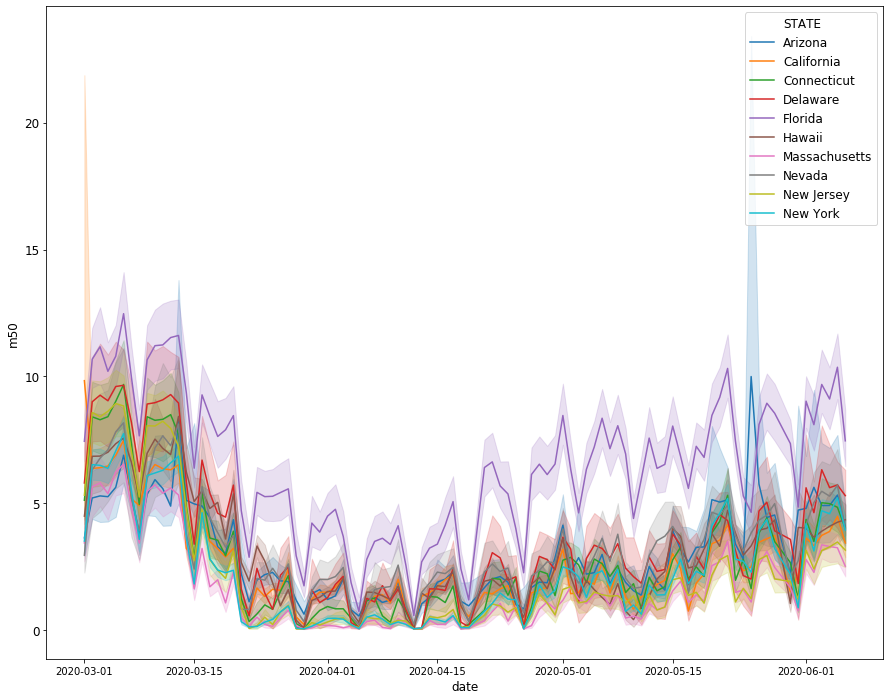

In [47]:
plt.figure(figsize=(15,12))
sns.lineplot(x='date', y = 'm50', hue='STATE', data=df_all_fil)